In [135]:
import os
from astropy.stats import LombScargle
import numpy as np
os.chdir('/home/jovyan/work')
import reading
%matplotlib inline

In [189]:
star = 138
curve = reading.read_lightcurve(star)

In [190]:
curve.describe()

,JD,V-C,s1,V,s2,C,s3,C1,s4,C2,...,C8,s11,C9,s12,C10,s13,C11,s14,C12,s15
count,7.870000e+02,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,...,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000
mean,2.457249e+06,0.360831,0.005041,13.416009,0.004720,13.055178,0.001759,11.469047,0.001513,12.451151,...,13.482612,0.004818,13.945442,0.007024,13.416311,0.004751,14.262894,0.008734,14.717653,0.012763
std,6.207008e+00,0.184701,0.001143,0.271931,0.001064,0.245934,0.000469,0.245546,0.000257,0.246096,...,0.247935,0.001197,0.247046,0.001836,0.248151,0.001188,0.244132,0.002446,0.247290,0.003894
min,2.457237e+06,-0.000610,0.003710,12.929140,0.003400,12.808980,0.001400,11.230120,0.001320,12.196650,...,13.228430,0.003950,13.691930,0.005610,13.158340,0.003870,14.015260,0.006840,14.466470,0.009790
25%,2.457245e+06,0.205335,0.004390,13.226160,0.004070,12.931335,0.001560,11.345330,0.001410,12.328020,...,13.357515,0.004345,13.821080,0.006230,13.291230,0.004250,14.142655,0.007720,14.592140,0.011080
50%,2.457249e+06,0.367870,0.004870,13.405190,0.004580,12.988660,0.001640,11.403510,0.001450,12.385070,...,13.418710,0.004530,13.879910,0.006580,13.350390,0.004460,14.195800,0.008130,14.653900,0.011790
75%,2.457255e+06,0.505475,0.005340,13.549580,0.005060,13.080815,0.001770,11.493785,0.001520,12.475505,...,13.510205,0.004805,13.967780,0.007070,13.444615,0.004770,14.287940,0.008735,14.744405,0.012885
max,2.457258e+06,0.693860,0.014640,14.841350,0.013560,14.726290,0.005530,13.162620,0.003680,14.117350,...,15.183420,0.014760,15.663800,0.022380,15.137470,0.014780,15.950350,0.029300,16.385480,0.045930


In [191]:
t = curve['JD']
y = curve['V-C']
dy = curve['s1']

t_np = t.as_matrix()
y_np = y.as_matrix()
dy_np = dy.as_matrix()
frequency, power = LombScargle(t_np, y_np, dy_np).autopower()

[4.74409349e-03 1.42322805e-02 2.37204675e-02 ... 9.33210631e+01
 9.33305513e+01 9.33400395e+01] [3.43275237e-02 3.32156700e-02 3.07361532e-02 ... 7.35580458e-05
 1.52004157e-04 3.09615849e-04]


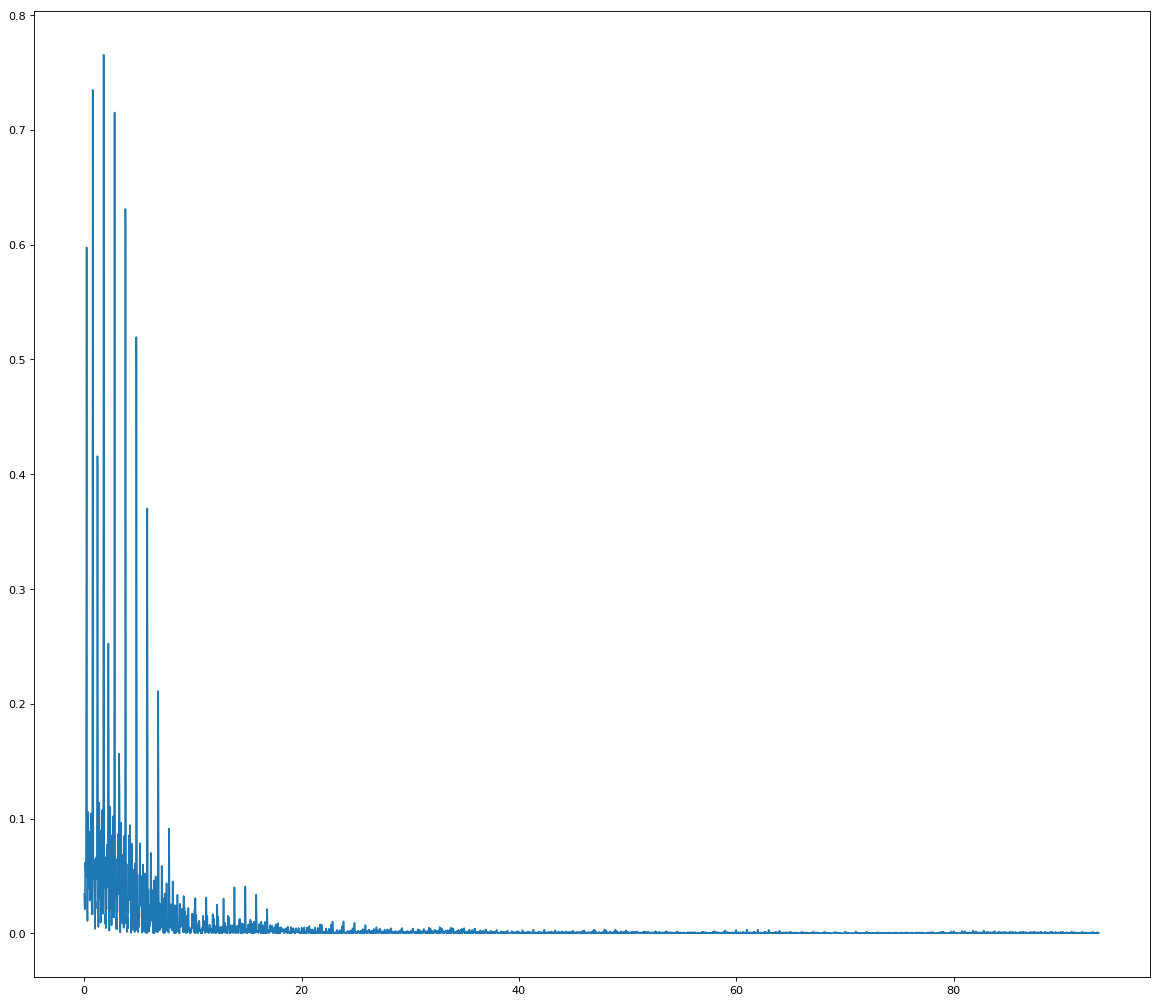

In [192]:
print(frequency, power)
import matplotlib.pyplot as plt  
#plt.plot(y)
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
#plt.errorbar(t,y,yerr=dy,linestyle='none',marker='o') 
plt.plot(frequency, power)   

plt.show()

In [193]:
best_frequency = frequency[np.argmax(power)]
t_fit = np.linspace(0, 1)
y_fit = LombScargle(t_np, y_np).model(t_fit, best_frequency)
print(best_frequency)

1.7885232465382785


Finding optimal frequency:
 - Estimated peak width = 0.298
 - Using 5 steps per peak; omega_step = 0.0596
 - User-specified period range:  0.01 to 21
 - Computing periods at 10536 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Best period: 0.5591501565036933 days
[ 0.1         0.10209809  0.10419619 ... 21.07464641 21.07674451
 21.0788426 ]


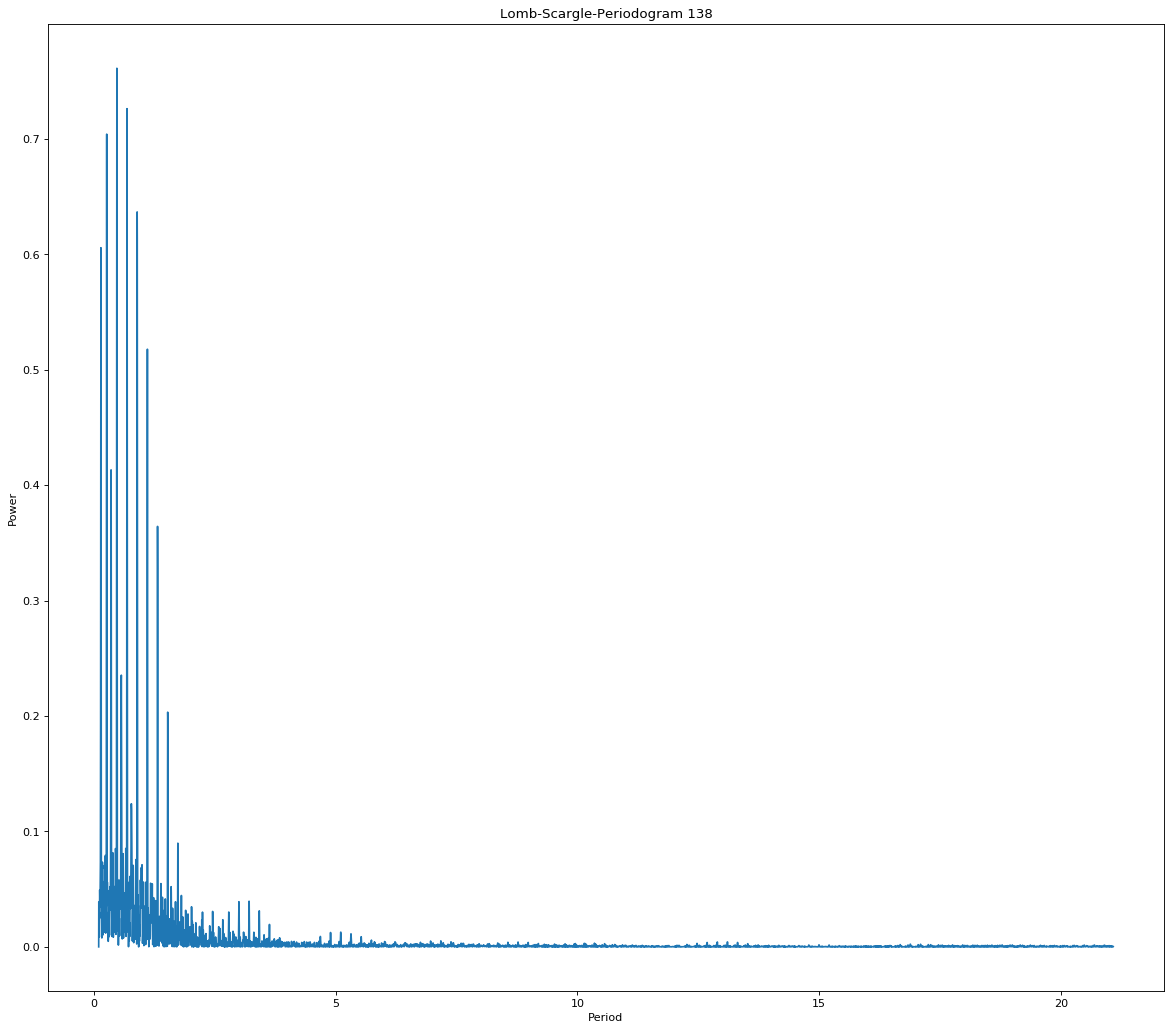

In [201]:
from gatspy.periodic import LombScargleFast

def gatspy_slow():
    ls = LombScargleFast()
    period_max = t_np[len(t_np)-1]-t_np[0]
    ls.optimizer.period_range = (0.01,period_max)
    ls.fit(t_np,y_np)
    period = ls.best_period
    print("Best period: " + str(period) + " days")
    # periodogramm
    periods = np.linspace(0.1,period_max,10000)
    scores = ls.score_frequency_grid(0,0.01, 10000)
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.xlabel("Period")
    plt.ylabel("Power")
    plt.title("Lomb-Scargle-Periodogram "+str(star))
    plt.plot(periods,scores)
    print(periods)
    return period

def gatspy_fast():
    fmin = 1. / periods.max()
    fmax = 1. / periods.min()
    N = 10000
    df = (fmax - fmin) / N

    model = LombScargleFast().fit(t_np, y_np)
    power = model.score_frequency_grid(fmin, df, N)
    freqs = fmin + df * np.arange(N)
    period = model.best_period

    # plot the results
    fig, ax = plt.subplots()
    ax.plot(1. / freqs, power)
    ax.set(ylim=(0, 0.8), xlabel='period (days)',
           ylabel='Lomb-Scargle Power');
    
def gatspy_fast2():
    model = LombScargleFast().fit(t_np, y_np)
    period, power = model.periodogram_auto(nyquist_factor=100)
    best_frequency = frequency[np.argmax(power)]
    print("period range: ({0}, {1})".format(period.min(), period.max()))
    print("number of periods: {0}".format(len(period)))
    print(best_frequency)
    return best_frequency
    
period = gatspy_slow()

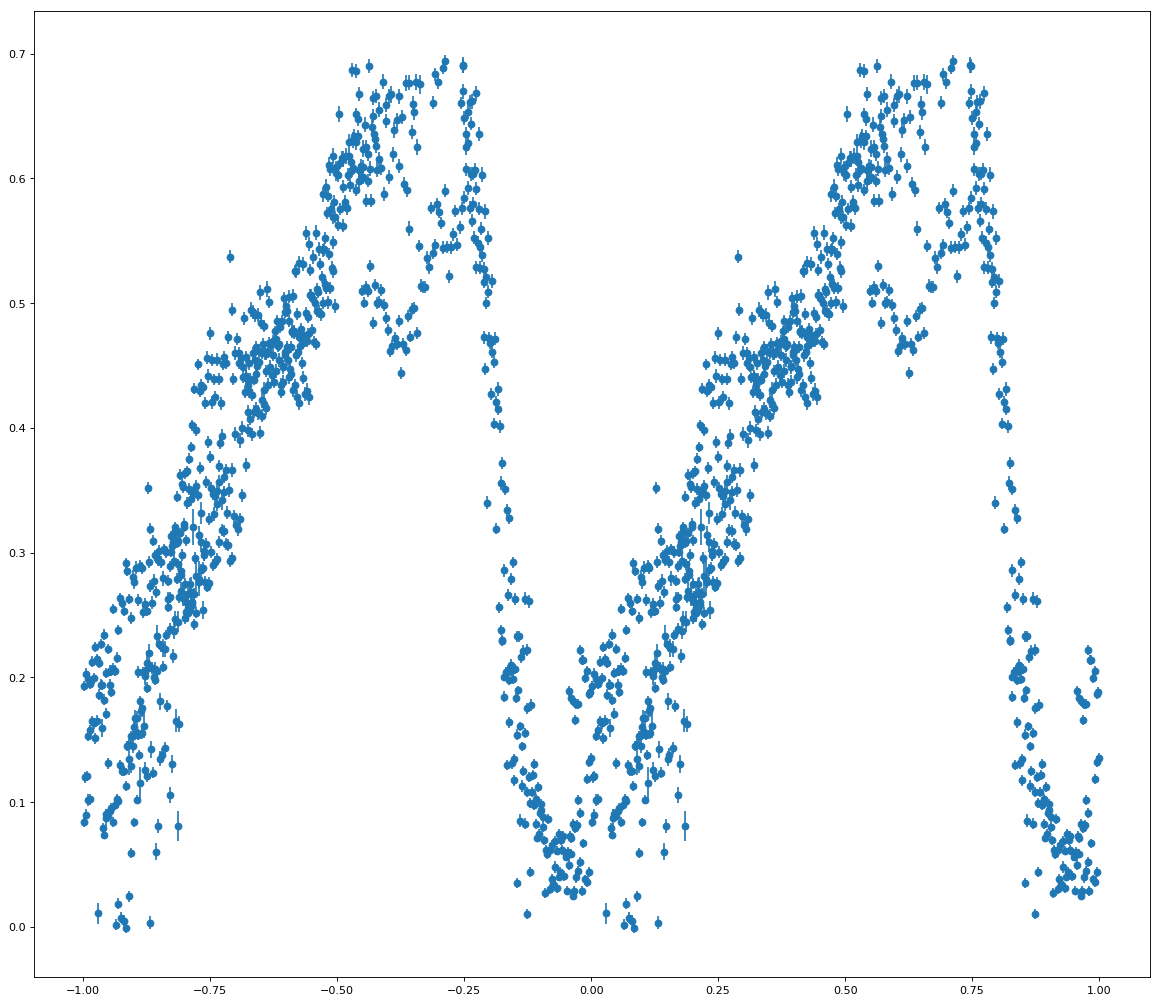

In [202]:
#plt.plot(t_fit, dy)  
# fold
#period = best_frequency            # period (must be known already!)
#period = 0.5594905

phased_t = np.fmod(t_np/period,1)
one_minus = lambda t: 1 - t
minus_one = lambda t: t - 1
minus_oner = np.vectorize(minus_one)
one_minuser = np.vectorize(one_minus)
phased_t2 = minus_oner(phased_t)
phased_lc = y_np[:]
phased_lc2 = one_minuser(phased_lc)
phased_t_final = np.append(phased_t2, phased_t)
phased_lc_final = np.append(phased_lc, phased_lc)
phased_err = np.append(dy, dy)
# plot folded lightcurve

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.errorbar(phased_t_final,phased_lc_final,yerr=phased_err,linestyle='none',marker='o')  
plt.show()